In [20]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import itertools
import math
import numpy

In [21]:
# Return the average in-degree of the given graph
def averageInDegree(G):
    # sum of the degrees of all its nodes divided by the number of nodes in the graph
    degreeSum = 0
    for node in G.nodes: 
        degreeSum += (G.in_degree[node])
    
    # divide by number of nodes
    return degreeSum/len(G.nodes)

In [ ]:
# Compute User Activity for the given node in network 
def UserActivity(G,node_num):
    
    return (G.in_degree[node_num]*random.random())/(len(G.nodes))

In [22]:
# Sigmoid scaling function to generate probabiltiies between 0 and 1 
def sigmoid(x):
    return ((2)/(1+math.exp(-x)))-1

In [23]:
# Compute tweet probability (f_u) for all nodes in G 
def compute_tweet_prob(G, TS, UA, scale_factor):
    scale_factor = scale_factor
    w_1 = 0.1
    w_2 = 1-w_1
    
    # compute f_u 
    f = (w_1*TS + w_2*UA)*scale_factor
        
    return f
    

In [24]:
# Compute IsMentioned variable for given tweeter (node1) and follower (node2)
def isMentioned(G,node1,node2):
    isMentioned = 0
    
    if node2 in list(G.neighbors(node1)) and node2 in list(G.predecessors(node1)):
        isMentioned = 1
        
    # add random factor 
    return isMentioned*random.random()

In [25]:
# Compute pairwise retweet probability (r_u) between the tweeting node (node1) and follower node (node2)
def compute_retweet_prob(G,node1,node2,scale_factor,TS,UA):
    scale_factor = scale_factor
    
    # Compute # common following
    node1_following = set(G.neighbors(node1))
    node2_following = set(G.neighbors(node2))
    
    num_common_following = len(node1_following.intersection(node2_following))
    
    # Compute # common followers
    node1_followers = set(G.predecessors(node1))
    node2_followers = set(G.predecessors(node2))
    
    num_common_followers = len(node1_followers.intersection(node2_followers))

    # Compute Similarity Score 
    w_following = 0.5
    w_followers = 1-w_following 
    
    SS = w_following*num_common_following + w_followers*num_common_followers
    
    # Compute IsMentioned
    IM = isMentioned(G,node1,node2)
    
    # Compute r_u 
    w_SS = 0.4
    w_TS = 0.1
    w_UA = 0.25
    w_IM = 0.25
    
    r_u = scale_factor*(w_SS*SS + w_TS*TS + w_UA*UA + w_IM*IM)
    
    return r_u

In [26]:
# Compute what the total sum of both in-degrees/out-degrees should be based on edge probability, p
def total_degree_sum(p, num_nodes):
    return p*(num_nodes**2)

In [27]:
import numpy as np 
# Create a degree distribution based on the total number of nodes and total in-degree/out-degree sum
def createRandomDist(num_nodes, totalDegSum):
    
    in_degrees = np.random.dirichlet(np.ones(numNodes-1),size=1)[0]
    out_degrees = np.random.dirichlet(np.ones(numNodes-1),size=1)[0]
    
    in_degrees_final = [int(d*totalDegSum) for d in in_degrees]
    out_degrees_final = [int(d*totalDegSum) for d in out_degrees]
    
    # create last value 
    in_deg_sum = sum(in_degrees_final)
    out_deg_sum = sum(out_degrees_final)
    
    diff = in_deg_sum - out_deg_sum 
    
    if diff<0:  # outdeg>indeg
        out_degrees_final.append(0)
        in_degrees_final.append((-1)*diff)
    elif diff>0: # indeg>outeg
        out_degrees_final.append(diff)
        in_degrees_final.append(0)
    else:
        rannum = random.randint(0,300)
        out_degrees_final.append(rannum)
        in_degrees_final.append(rannum)
    
    return in_degrees_final, out_degrees_final


In [48]:
# Modified Forest Fire Algorithm 
# Inputs: graph (G), dictionary of tweet probabilites (f), dictionary of retweet probabilities (r)
# tweet probability threshold (f_0), retweet probability threshold (r_0)
# Output: S - list of spreaders, N - list of nonspreaders
# (For graphing purposes): num_spreaders, num_nonspreaders, and num_trees - lists containing the number of 
# nodes in each category at each iteration 
# iterations - the total number of iterations
def mff(G, f, r, f_0, r_0):
    S = set()
    N = set()
    fire = [] 
    num_spreaders = []
    num_nonspreaders = []
    num_trees = []
    iterations = 0
    status = {}
    
    
    # Initialize statuses of nodes based ont weet probabilities
    for node in G.nodes(): 
        if f[node] >= f_0: 
            status[node] = 1
            fire.append(node)
            S.add(node)
        else: 
            status[node] = 0

    # Loop through all nodes on fire and check on their neighbors 
    while (len(fire)!=0):
        node = fire.pop()
        
        # Check neighbros of node on fire
        for neighbor in G.predecessors(node):
            if status[neighbor] == 0 or status[neighbor] == -1: 
                if r[(node,neighbor)]>= r_0:
                    status[neighbor] = 1
                    fire.append(neighbor)
                    S.add(neighbor)
                    if neighbor in N: 
                        N.remove(neighbor)
                else: 
                    status[neighbor] = -1
                    N.add(neighbor)
        
            # Keep track of composition of nodes at this iteration 
            num_spreaders.append(len(S))
            num_nonspreaders.append(len(N))
            num_trees.append(len(G.nodes)-(len(S)+len(N)))
                
            iterations= iterations + 1


    return S,N, num_spreaders, num_nonspreaders, num_trees, iterations
                

# Run 1

In [29]:
# Define Graph 
numNodes = 5000
p = 0.15
averageDeg = numNodes*p
totalDegSum = total_degree_sum(p,numNodes)

degree = createRandomDist(numNodes,totalDegSum)
in_degrees = degree[0]
out_degrees = degree[1]

In [30]:
# Define graph using random distribution 
G1 = nx.directed_configuration_model(in_degree_sequence = in_degrees,out_degree_sequence = out_degrees)

In [31]:
# Compute all user activities 
UA = {}
for node in G1.nodes: 
    UA[node] = UserActivity(G1,node)

# Define topic significance
TS = 1

In [44]:
# Compute tweet probabilities for each node and pass through sigmoid function
f_u = {}
f_u_sigmoid = {}
scale_factor = 1.7

for node in G1.nodes: 
    # compute this nodes tweet probability using topic significance, user activity, and the scale factor
    f =  compute_tweet_prob(G1,TS,UA[node],scale_factor)
    f_u[node]=f
    f_u_sigmoid[node] = sigmoid(f)

In [45]:
# Compute retweet probabilities for each user-follower pair (each connected pair of nodes) + pass through sigmoid function
r_u = {}
r_u_sigmoid = {}
scale_factor = 1

for node in G1.nodes: 
    # Loop through followers of each node to compute their retweet probability 
    for follower in G1.predecessors(node):
        r = compute_retweet_prob(G1,node,follower,scale_factor,TS,UA[node])
        r_u[(node,follower)] = r
        r_u_sigmoid[(node,follower)] = sigmoid(r)



In [46]:
# Helper function to scale tweet probabilites for below graph 
def scale_tweet_probs(scale_factor,f_u_init, f_u_sigmoid_init): 
    #f_u_copy = copy.deepcopy(f_u_init)
    f_u_scaled = {}
    f_u_sigmoid_scaled = {}
    
    for node in f_u_init: 
        # compute f_u 
        f = f_u_init[node]*scale_factor 
        f_u_scaled[node]=f
        f_u_sigmoid_scaled[node] = sigmoid(f)
        
    return f_u_scaled, f_u_sigmoid_scaled

In [50]:
# Run simulation on graph with the scaled tweet and retweet probabilities and thresholds of 0.5 as parameters 
r_0 = 0.5
f_0 = 0.5
lists = mff(G1,f_u_sigmoid,r_u_sigmoid,f_0,r_0)

# Save outputs 
S = lists[0]
N = lists[1]

num_S = lists[2]
num_N = lists[3]
num_T = lists[4]

iterations = lists[5]


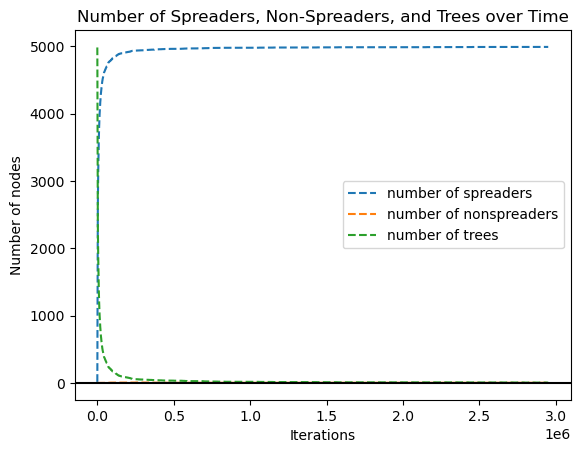

In [51]:
# Plot the number of spreaders and non-spreaders over iterations 
import matplotlib.pyplot as plt

plt.plot(num_S, label='number of spreaders',linestyle='dashed')
plt.plot(num_N, label='number of nonspreaders',linestyle='dashed')
plt.plot(num_T, label='number of trees',linestyle='dashed')
plt.axhline(y=0, color='black', linestyle='-')

plt.xlabel('Iterations')
plt.ylabel('Number of nodes')
plt.title('Number of Spreaders, Non-Spreaders, and Trees over Time')
plt.legend()
plt.show()